In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#loading the files to sync with the images collected in data_fethcer.py
train_df = pd.read_csv('train(1).csv')
test_df = pd.read_csv('test2.csv')

def sync(df, folder_path):
    downloaded_ids = [int(f.split('.')[0]) for f in os.listdir(folder_path) if f.endswith('.jpg')]
    return df[df['id'].isin(downloaded_ids)].copy()

train_df = sync(train_df, 'images/train')
test_df = sync(test_df, 'images/test')

print(f"Synced Training Rows: {len(train_df)}")
print(f"Synced Testing Rows: {len(test_df)}")

Synced Training Rows: 16209
Synced Testing Rows: 5404


In [7]:
train_df['bedrooms'] = pd.to_numeric(train_df['bedrooms'], errors='coerce')
train_df['sqft_living'] = pd.to_numeric(train_df['sqft_living'], errors='coerce')

#calculating the squarefeet per bedrroom ratio to flag outliers that violate the minimum standard of 70 sqft
train_df['sqft_per_bedroom'] = train_df['sqft_living'] / train_df['bedrooms']

lim = 70
anomalies = train_df[train_df['sqft_per_bedroom'] < lim]

print(f"flagging outliers (< {lim} sqft/bedroom)...")

if not anomalies.empty:
    print(f"code flagged {len(anomalies)} items:")
    display(anomalies[['id', 'bedrooms', 'sqft_living', 'sqft_per_bedroom']])
    
    #replacing number of rooms with median, i.e. 3 rooms
    train_df.loc[anomalies.index, 'bedrooms'] = 3
    print("Flagged values were corrected")
else:
    print("No items were flagged")

flagging outliers (< 70 sqft/bedroom)...
code flagged 1 items:


,id,bedrooms,sqft_living,sqft_per_bedroom
3193,2402100895,33,1620,49.090909


Flagged values were corrected


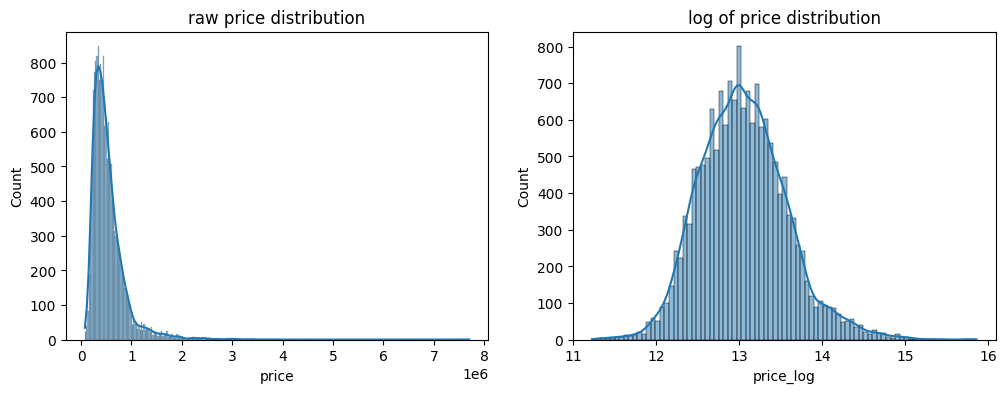

In [8]:
#applying log transofmration to get a gauss dirstibution for stable training
train_df['price_log'] = np.log1p(train_df['price'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train_df['price'], kde=True, ax=ax[0]).set_title('raw price distribution')
sns.histplot(train_df['price_log'], kde=True, ax=ax[1]).set_title('log of price distribution')
plt.show()

In [9]:
def engineer_temporal_features(df):
    
    df['date'] = pd.to_datetime(df['date'])
    df['year_sold'] = df['date'].dt.year
    df['month_sold'] = df['date'].dt.month
    df['house_age'] = df['year_sold'] - df['yr_built']
    #adding binary datatpye for rennovatiion
    df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
    
    #calculating years since last update
    df['years_since_update'] = df.apply(
        lambda x: x['year_sold'] - x['yr_renovated'] if x['yr_renovated'] > 0 
        else x['year_sold'] - x['yr_built'], axis=1
    )
    return df

train_df = engineer_temporal_features(train_df)
test_df = engineer_temporal_features(test_df)

print("table after creating temporal features : ")
display(train_df[['date', 'house_age', 'is_renovated', 'years_since_update']].head())

table after creating temporal features : 


,date,house_age,is_renovated,years_since_update
0,2015-05-05,54,0,54
1,2014-07-08,22,0,22
2,2015-01-15,21,0,21
3,2015-04-27,6,0,6
4,2014-12-05,20,0,20


In [11]:
#defiining other numerical features
scale_cols = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
    'sqft_basement', 'house_age', 'years_since_update', 'month_sold'
]

scaler = MinMaxScaler()
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

#dropping redundant columns
to_drop = ['date', 'yr_built', 'yr_renovated', 'year_sold', 'sqft_per_bedroom', 
              'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

train_df_final = train_df.drop(columns=to_drop, errors='ignore')
test_df_final = test_df.drop(columns=to_drop, errors='ignore')

#saving the pre processed datasets
train_df_final.to_csv('train_preprocessed.csv', index=False)
test_df_final.to_csv('test_preprocessed.csv', index=False)

print("pre processing complete!")
print(f"Final Train CSV Shape: {train_df_final.shape}")
print(f"Final Test CSV Shape: {test_df_final.shape}")

pre processing complete!
Final Train CSV Shape: (16209, 18)
Final Test CSV Shape: (5404, 16)
